In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}

facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'

def plot_graphs(df,country,save_fig_path):

    df=df.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3':'RGB-0.3','Rgb0.5':'RGB-0.5','Spread':'SPREAD'})

    index = ['ORIGINAL','GREYSCALE','RGB-0.3','RGB-0.5','SPREAD','MASKED']
    
    df_res = df.copy()
    df_res = df_res[[0]+index]
    df_res.to_csv(save_fig_path.split('gender_wise')[0]+'accuracy_'+country+'.csv',index = False)
    
    column0 = []
    column1 = []
    for col in index:
        column0.append(df[col][1])
        column1.append(df[col][2])
    title0 = 'Male'
    title1 = 'Female'
    
    fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
    fig.tight_layout()

    axes[0].barh(index, column0, align='center', color=color_red)
    axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
    axes[1].barh(index, column1, align='center', color=color_blue)
    axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
    
    # If you have positive numbers and want to invert the x-axis of the left plot
    axes[0].invert_xaxis() 

    # To show data from highest to lowest
    plt.gca().invert_yaxis()


    axes[0].set(yticks=index, yticklabels=index)
    axes[0].yaxis.tick_left()
    axes[0].tick_params(axis='y', colors='white') # tick color

    ticks = list(np.linspace(0,100,11,dtype = 'int'))
    axes[1].set_xticks(ticks)
    axes[1].set_xticklabels(ticks)

    axes[0].set_xticks(ticks)
    axes[0].set_xticklabels(ticks)

    for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
        label.set(fontsize=13, color=font_color, **hfont)
    for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
        label.set(fontsize=13, color=font_color, **hfont)
        

    
    for i, acc in enumerate(column0):
        axes[0].text(acc-2,i, acc, color='black', fontweight='bold',fontsize = 12)
    
    for i, acc in enumerate(column1):
        axes[1].text(acc+2,i, acc, color='black', fontweight='bold',fontsize = 12)

    plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
    
    fig.supxlabel("Accuracy (%)")
    fig.supylabel("Image Type")
    fig.suptitle(country, fontsize=15)
    plt.savefig(save_fig_path+country+'.png',bbox_inches ="tight",dpi = 150)
    plt.show()

In [3]:
def plot_graph_overall(df,country,save_fig_path):
    df=df.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3':'RGB-0.3','Rgb0.5':'RGB-0.5','Spread':'SPREAD'})
    
    index = ['ORIGINAL','GREYSCALE','RGB-0.3','RGB-0.5','SPREAD','MASKED']
    values = []
    for col in index:
        values.append(df[col][0])
    fig, ax = plt.subplots(figsize = (8, 4),facecolor=facecolor)
    ax.bar(index,values,color = "#0A4D68")
        
    for i,acc in enumerate(values):
        ax.text(i-0.2,acc-6.5,acc,color='white', fontweight='bold',fontsize = 12)
    
    plt.ylim(0,100)
    plt.xlabel("Image Type")
    plt.ylabel("Accuracy (%)")
    plt.title(country)
    plt.savefig(save_fig_path+country+"_overall"+'.jpg',dpi = 150)
    plt.show()

In [4]:

def doAnalysis(fileName,country,image_file_path,save_fig_path,status_csv_file):
    df = pd.read_csv(fileName)
    df_status = pd.read_csv(status_csv_file+".csv")
    #######################################################################################################
    ## All the players with JSON file don't have images (Due to YOLO or MASK some of the images did not generated)
    # to get the correct number of images which are tested in the API are needed
    df['valid normal'] = 0
    df['valid masked'] = 0
    image_folder_normal = image_file_path+country+"_resized/normal/"
    image_folder_masked = image_file_path+country+"_resized/masked/"
    
    # Process the normal images
    image_files = os.listdir(image_folder_normal)
    for name in image_files:
        name = name.split('.')[0]
        rowInd = df.index[df['name'] == name].tolist()[0]
        df.at[rowInd,'valid normal'] = 1
    
    #Process the masked images
    image_files = os.listdir(image_folder_masked)
    for name in image_files:
        name = name.split('.')[0].split('_N95')[0]
        rowInd = df.index[df['name'] == name].tolist()[0]
        df.at[rowInd,'valid masked'] = 1
        
    df.to_csv(fileName,index=False)
    
    ##################################################################################################
    columns = df.columns[2:-2]
    df_res = pd.DataFrame(['Overall','Male','Female'])

    for column in columns:
        ################# Consider only valid images for analysis ##############
        df_res[column.title()] = None
        image_type = 'normal'
        if column == 'masked':
            image_type = 'masked'
        df_copy = df[['name','gender',column,'valid '+image_type]]
        df_copy=df_copy.rename(columns = {'valid '+image_type:'valid'})
        df_copy = df_copy[df_copy['valid'] == 1]
        
        ############ There are some greyscale and cartoonish images in the folder, we should  ############
        ##### not consider those images for our accuracy plot #####
        img_type = column.split()[0].lower()
        df_status['fileName'] = df_status['fileName'].apply(lambda x: x.split(".")[0])
        df_copy = df_copy.merge(df_status, left_on='name', right_on='fileName', how='inner')[['name','gender', column,'valid', 'status']]
        if img_type == "greyish":
            df_copy = df_copy[df_copy['status'].isin(['OK', 'GREY'])]
        else:
            df_copy = df_copy[df_copy['status'] == 'OK']
            
#         print(df_copy)
        ###################################################################
        
#         column = column.capitalize()
        total = len(df_copy)
        df_male = df_copy.copy()
        df_male = df_male[df_male['gender'] == 'M']
        df_female = df_copy.copy()
        df_female = df_female[df_female['gender'] == 'F']
        
        total_male = len(df_male)
        total_female = len(df_female)
        
        total_correct_prediction = len(df_copy[df_copy['gender'] == df_copy[column]])
        correct_prediction_male = len(df_male[df_male['gender'] == df_male[column]])
        correct_prediction_female = len(df_female[df_female['gender'] == df_female[column]])
        
        overall_accuracy = (total_correct_prediction/total)*100
        male_accuracy = (correct_prediction_male/total_male)*100
        female_accuracy = (correct_prediction_female/total_female)*100
        
        df_res[column.title()][0] = round(overall_accuracy,2)
        df_res[column.title()][1] = round(male_accuracy,2)
        df_res[column.title()][2] = round(female_accuracy,2)
        
#     print(df_res)
#     print()
    df_res.to_csv(save_fig_path+'accuracy_'+country+'.csv',index = False)
    print("########### ",country," ###########")
    try:
        plot_graphs(df_res,country,save_fig_path+"gender_wise/")
        plot_graph_overall(df_res,country,save_fig_path+"overall/")
    except:
        pass

In [5]:
def analysis(API_NAME,country,path,ground_path):
    try:
        os.mkdir("./../Results in csv files/")
    except:
        pass
    try:
        os.mkdir("./../Results in csv files/"+API_NAME+"/")
    except:
        pass
    
    image_types = os.listdir(path+country+"/")
    
    # ================ Read the JSON file (Ground Truth of images) =======================
    ground_path_country = ground_path+country
    allFiles = os.listdir(ground_path_country)
    df = pd.DataFrame()
    df['name'] = None
    df['gender'] = None
    for file in allFiles:
        f = open(ground_path_country+'/'+file)
        data = json.load(f)
        name = file.split('.')[0]
        gender = data['gender']
        df.loc[len(df.index)] = [name,gender]
        f.close()
    print("############################## "+country+" ##############################")
#     print("Ground Truth Data reading DONE")
#     print(df)
    #====================================================================================
            
    for image_type in image_types: #['greyish','original','rgb0.3',...]
        image_type = image_type.split('.txt')[0]
        file_path = path+country+"/"+image_type+".txt"
        image_type = image_type.split()[0]
        df[image_type] = None
        f = open(file_path,'r')
        lines = f.readlines()
        f.close()
        for line in lines:
            name = line.split('.jpg')[0].split('_N95')[0]
            gender = line.split('.jpg')[1].split()[0].strip()[0]
            try:
                rowInd = df.index[df['name'] == name].tolist()[0]
                df.at[rowInd,image_type] = gender
            except:
                continue
    out_path = "./../Results in csv files/"+API_NAME+"/"+country+'.csv'
    df.to_csv(out_path,index=False)

In [6]:
API_NAME = 'libfaceid' #Enter API name

ground_path = "./../Details/"
path = "./../API Result SJ/"+API_NAME+'/'
countries = os.listdir(path)
# for country in countries:
#     analysis(API_NAME,country,path,ground_path)

###########  Australia  ###########


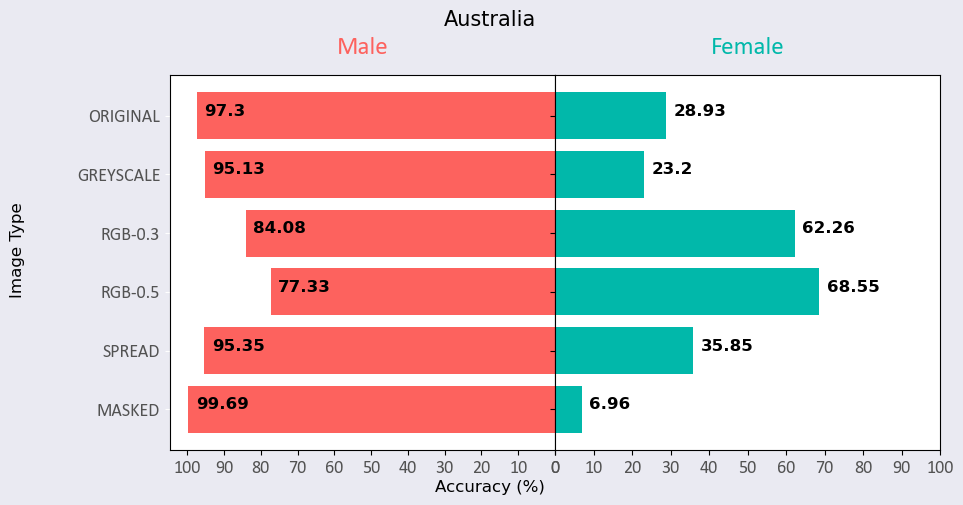

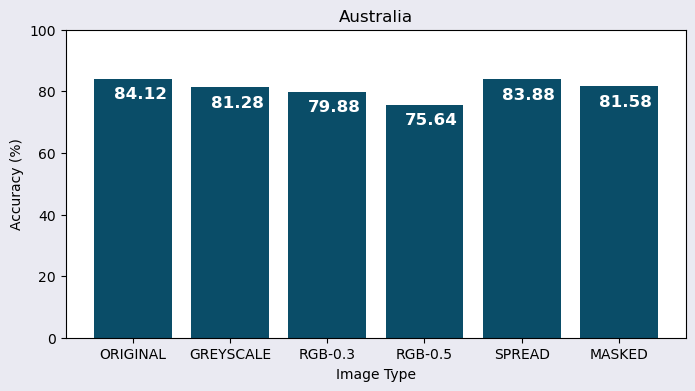

###########  Bangladesh  ###########


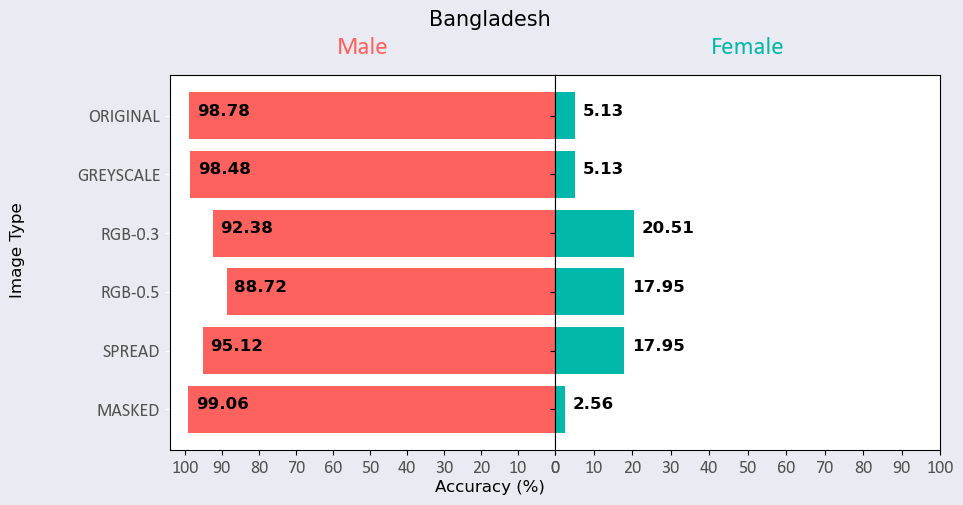

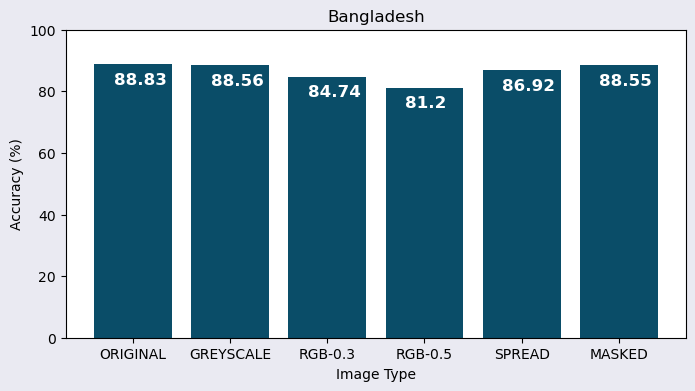

###########  England  ###########


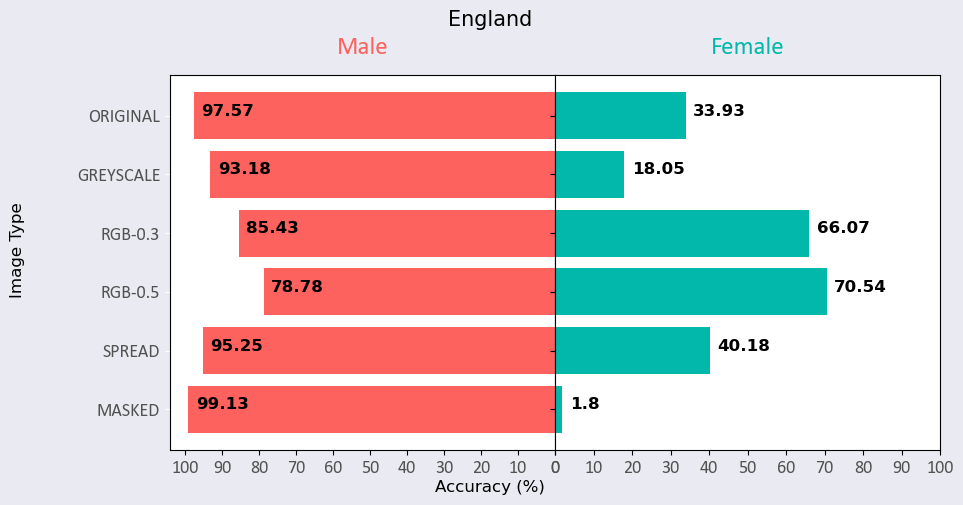

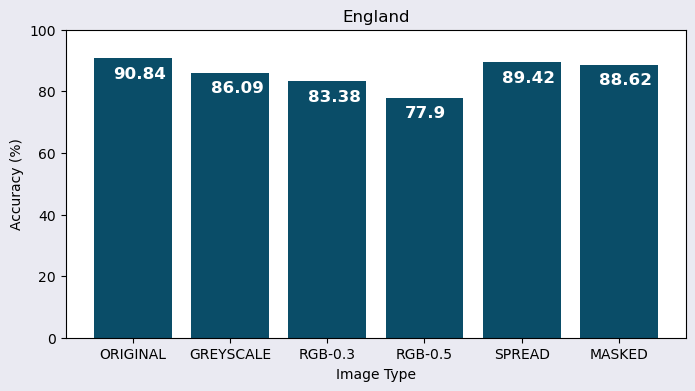

###########  India  ###########


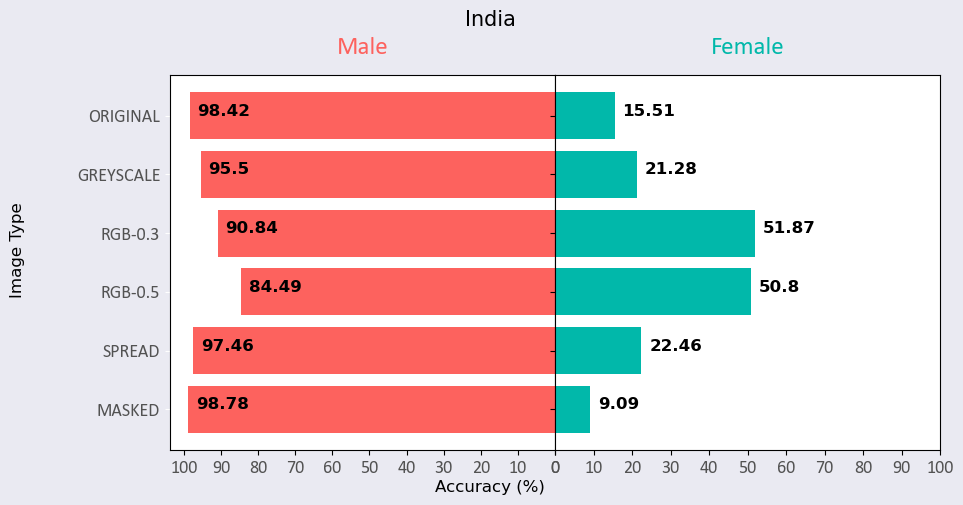

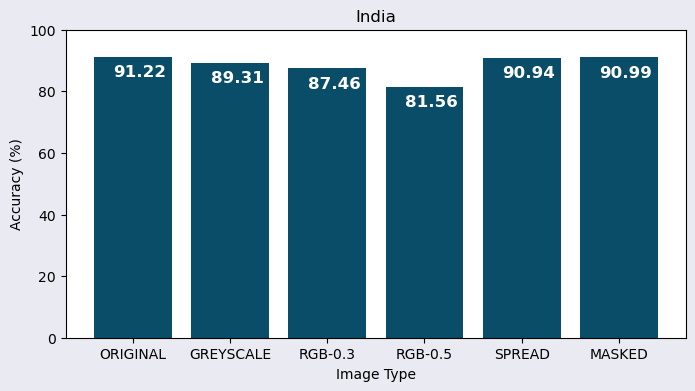

###########  New Zealand  ###########


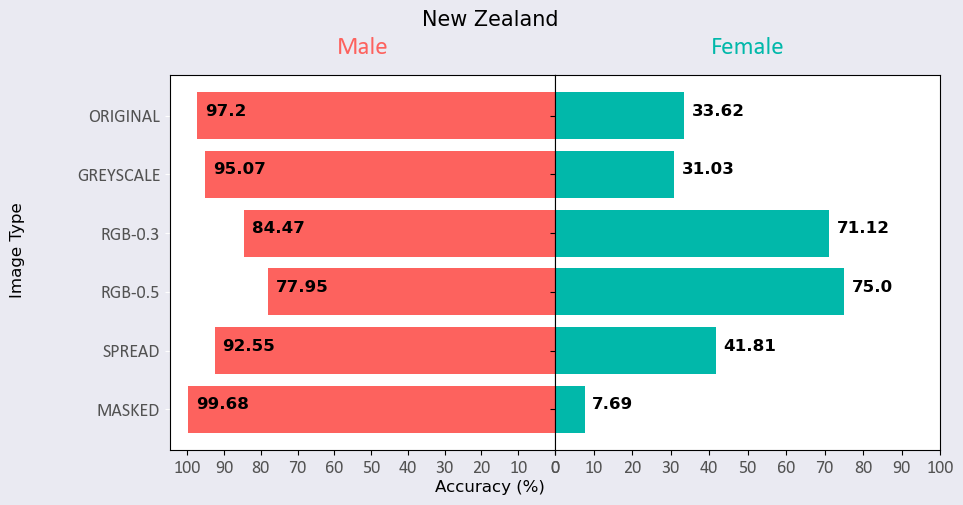

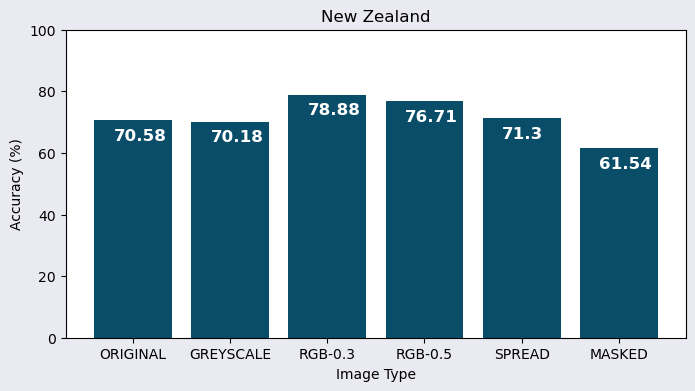

###########  Pakistan  ###########


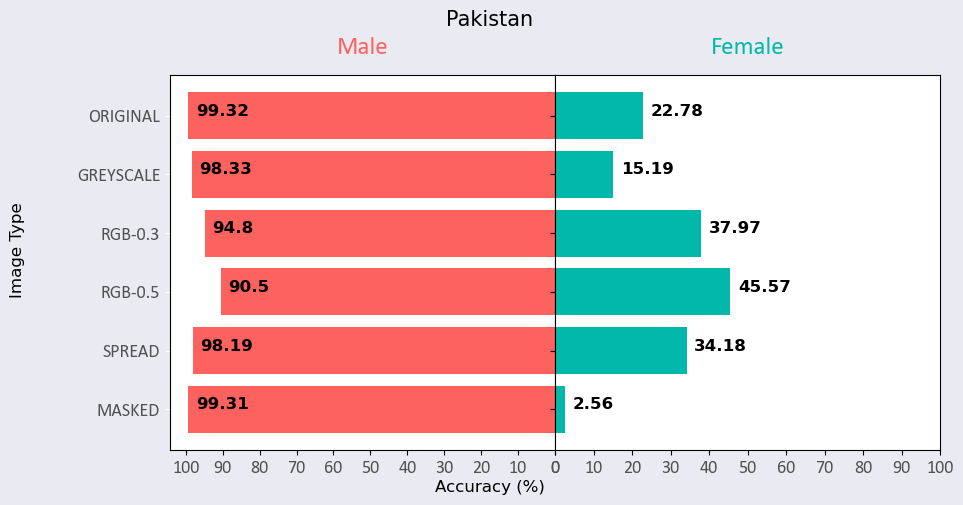

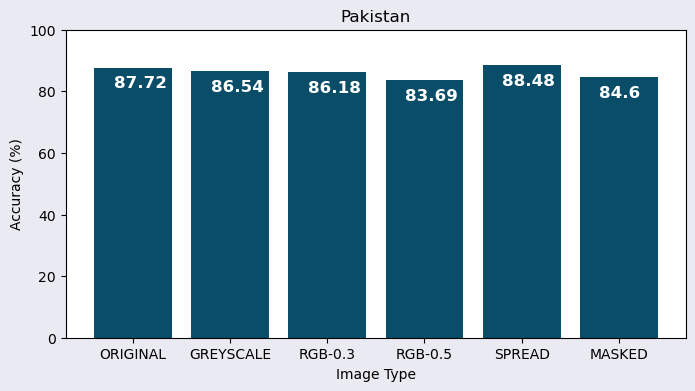

###########  South Africa  ###########


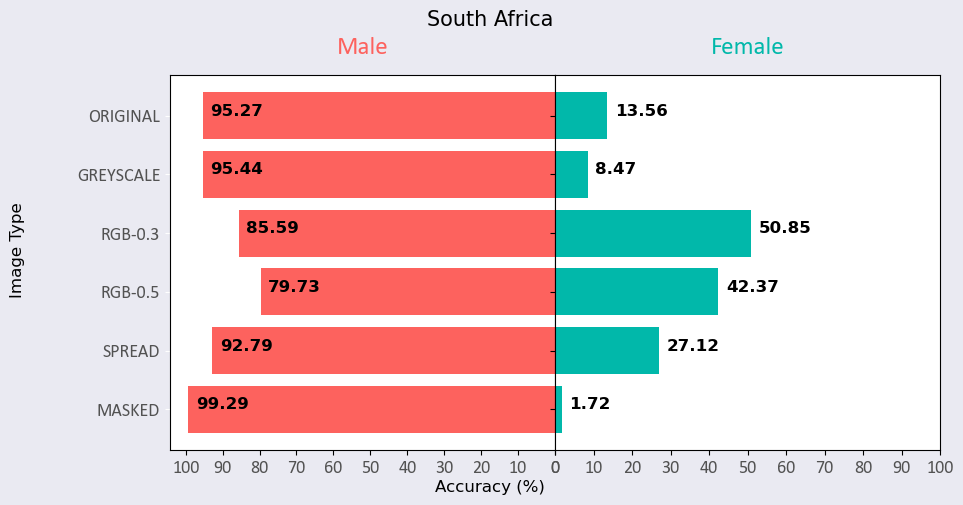

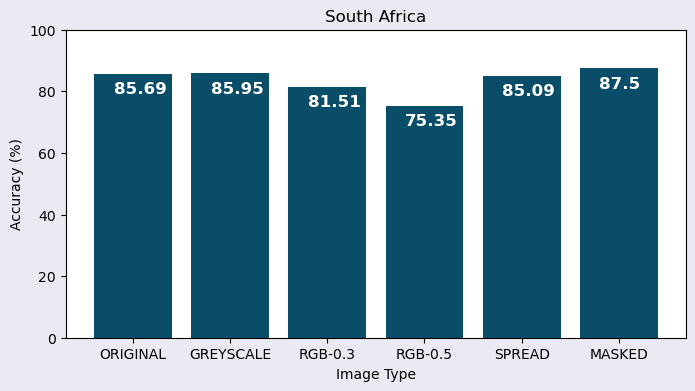

###########  West Indies  ###########


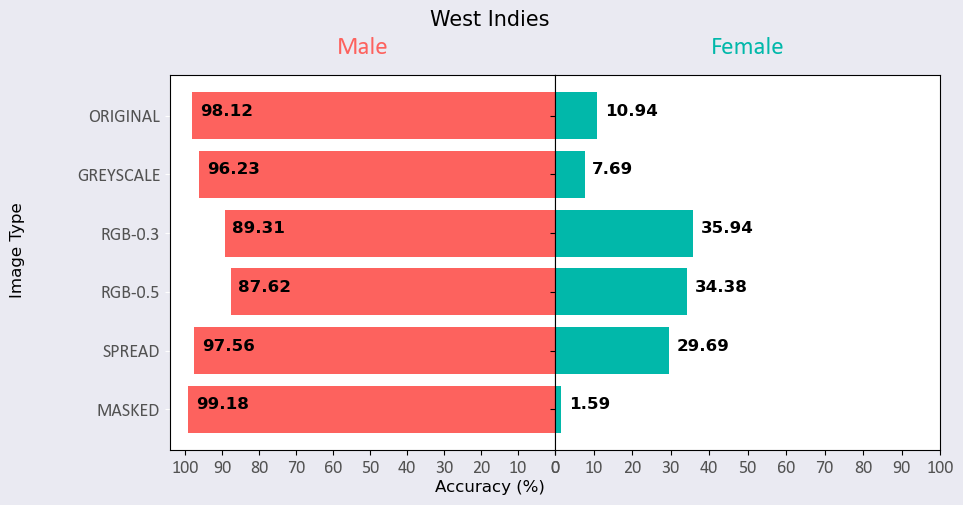

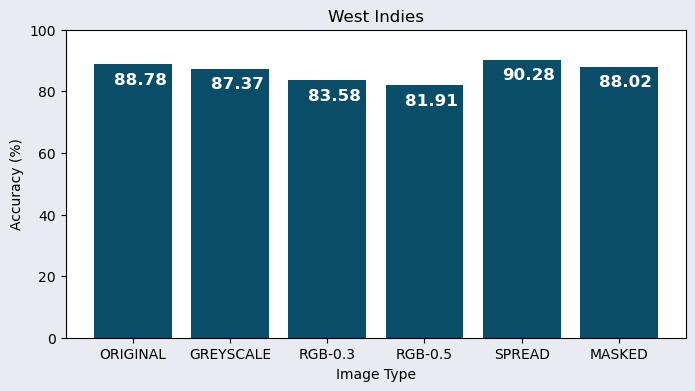

In [7]:
image_file_path = "./../All Face Images with And Without Mask (N95)/"
status_csv_file = "./../correction/status_csv_files/"

try:
    os.mkdir("./../plots/")
except:
    pass
try:
    os.mkdir("./../plots/"+API_NAME)
except:
    pass

try:
    os.mkdir("./../plots/"+API_NAME+'/overall')
except:
    pass
try:
    os.mkdir("./../plots/"+API_NAME+'/gender_wise')
except:
    pass

save_fig_path = "./../plots/"+API_NAME+"/"
countries = os.listdir(path)
for country in countries:
    filePath = "./../Results in csv files/"+API_NAME+"/"+country+'.csv'
    doAnalysis(filePath,country,image_file_path,save_fig_path,status_csv_file+country)